___

<a href='https://sites.google.com/fat.uerj.br/livia'> <img src='../../figures/capa2.png' /></a>
___

In [1]:
path_data = '../../data/'
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

# Teste A/B
Na análise de dados moderna, decidir se duas amostras numéricas vêm da mesma distribuição subjacente é chamado de *teste A/B*. O nome refere-se aos rótulos das duas amostras, A e B.

Desenvolveremos o método no contexto de um exemplo. Os dados vêm de uma amostra de recém-nascidos em um grande sistema hospitalar. Vamos tratá-lo como se fosse uma amostra aleatória simples, embora a amostragem tenha sido feita em vários estágios. [Stat Labs](https://www.stat.berkeley.edu/~statlabs/) por Deborah Nolan e Terry Speed tem detalhes sobre um conjunto de dados maior do qual este conjunto é extraído.

## Smokers and Nonsmokers
The table `births` contains the following variables for 1,174 mother-baby pairs: the baby's birth weight in ounces, the number of gestational days, the mother's age in completed years, the mother's height in inches, pregnancy weight in pounds, and whether or not the mother smoked during pregnancy.

In [4]:
births = pd.read_csv(path_data + 'baby.csv')

births.head(10)

,Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
0,120,284,27,62,100,False
1,113,282,33,64,135,False
2,128,279,28,64,115,True
3,108,282,23,67,125,True
4,136,286,25,62,93,False
5,138,244,33,62,178,False
6,132,245,23,65,140,False
7,120,289,25,62,125,False
8,143,299,30,66,136,True
9,140,351,27,68,120,False


Um dos objetivos do estudo foi verificar se o tabagismo materno estava associado ao peso ao nascer. Vejamos o que podemos dizer sobre as duas variáveis.

Começaremos selecionando apenas `Peso de Nascimento` e `Fumante Materno`. Há 715 não fumantes entre as mulheres da amostra e 459 fumantes.

In [5]:
smoking_and_birthweight = births.loc[:, ['Maternal Smoker', 'Birth Weight']]

In [6]:
smoking_and_birthweight.groupby('Maternal Smoker').count()

,Birth Weight
Maternal Smoker,
False,715
True,459


Vejamos a distribuição dos pesos ao nascer dos bebês das mães não fumantes em comparação com os das mães fumantes. Para gerar dois histogramas sobrepostos, usaremos o metodo `histplot` do pacote `seaborn` com o argumento opcional `hue` que é um rótulo de coluna ou índice. As linhas da tabela são primeiro agrupadas por esta coluna e então um histograma é desenhado para cada uma.

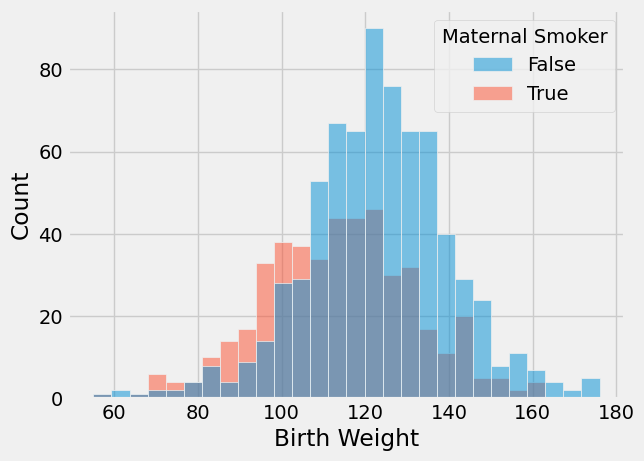

In [9]:
sns.histplot(data = smoking_and_birthweight, x = 'Birth Weight', hue = 'Maternal Smoker');

A distribuição dos pesos dos bebês nascidos de mães fumantes parece se basear ligeiramente à esquerda da distribuição correspondente às mães não fumantes. Os pesos dos bebês das mães que fumam parecem menores em média do que os pesos dos bebês das não-fumantes.

Isso levanta a questão de saber se a diferença reflete apenas uma variação aleatória ou uma diferença nas distribuições na população maior. Será que não há diferença entre as duas distribuições na população, mas estamos vendo uma diferença nas amostras apenas por causa das mães que foram selecionadas?

## As Hipóteses
Podemos tentar responder a essa pergunta por meio de um teste de hipóteses. O modelo de chance que testaremos diz que não há diferença subjacente nas populações; as distribuições nas amostras são diferentes apenas devido ao acaso.

Formalmente, esta é a hipótese nula. Teremos que descobrir como simular uma estatística útil sob esta hipótese. Mas, para começar, vamos apenas expor as duas hipóteses naturais.

**Hipótese nula:** Na população, a distribuição do peso ao nascer dos bebês é a mesma para mães que não fumam e para mães que fumam. A diferença na amostra é devido ao acaso.

**Hipótese alternativa:** Na população, os bebês das mães que fumam têm, em média, um peso ao nascer menor do que os bebês das não fumantes.

## Estatística de teste
A hipótese alternativa compara os pesos médios ao nascer dos dois grupos e diz que a média das mães que fumam é menor. Portanto, é razoável usarmos a diferença entre as médias dos dois grupos como nossa estatística.

Faremos a subtração na ordem "peso médio do grupo de fumantes $-$ peso médio do grupo de não fumantes". Pequenos valores (ou seja, grandes valores negativos) dessa estatística favorecerão a hipótese alternativa.

O valor observado da estatística de teste é de cerca de $-9,27$ onças.

In [12]:
means_table = smoking_and_birthweight.groupby('Maternal Smoker').mean()
means_table

,Birth Weight
Maternal Smoker,
False,123.085315
True,113.819172


In [16]:
means = means_table['Birth Weight']
observed_difference = means[1] - means[0]
observed_difference

-9.266142572024918

Vamos calcular essas diferenças repetidamente em nossas simulações abaixo, então definiremos uma função para fazer o trabalho. A função recebe dois argumentos:

- o nome da tabela de dados
- o rótulo da coluna que contém a variável booleana para agrupamento

Retorna a diferença entre as médias do grupo `True` e do grupo `False`.

Você logo verá por que estamos especificando os dois argumentos. Por enquanto, apenas verifique se a função retorna o que deveria.

In [17]:
def difference_of_means(table, group_label):
    """Takes: name of table,
    column label that indicates the group to which the row belongs
    Returns: Difference of mean birth weights of the two groups"""
    reduced = table.loc[:, ['Birth Weight', group_label]]
    means_table = reduced.groupby(group_label).mean()
    means = means_table['Birth Weight']
    return means[1] - means[0]

Para verificar se a função está funcionando, vamos usá-la para calcular a diferença observada entre os pesos médios ao nascer dos dois grupos da amostra.

In [16]:
difference_of_means(births, 'Maternal Smoker')

-9.266142572024918

Isso é o mesmo que o valor de `diferença_observada` calculado anteriormente.

## Prevendo a estatística sob a hipótese nula

Para ver como a estatística deve variar sob a hipótese nula, temos que descobrir como simular a estatística sob essa hipótese. Um método inteligente baseado em *permutações aleatórias* faz exatamente isso.

Se não houvesse diferença entre as duas distribuições na população subjacente, então se um peso ao nascer tem o rótulo 'Verdadeiro' ou 'Falso' em relação ao tabagismo materno não deveria fazer diferença para a média. A ideia, então, é embaralhar todos os rótulos aleatoriamente entre as mães. Isso é chamado de *permutação aleatória*.

O embaralhamento garante que a contagem de rótulos `True` não mude, nem a contagem de rótulos `False`. Isso é importante para a comparabilidade das diferenças de médias simuladas e da diferença de médias original. Veremos mais adiante no curso que o tamanho da amostra afeta a variabilidade de uma média amostral.

Pegue a diferença das duas novas médias de grupo: o peso médio dos bebês cujas mães foram rotuladas aleatoriamente como fumantes e o peso médio dos bebês das mães remanescentes que foram todas rotuladas aleatoriamente como não fumantes. Este é um valor simulado da estatística de teste sob a hipótese nula.

Vamos ver como fazer isso. É sempre uma boa ideia começar com os dados. Reduzimos a tabela para ter apenas as colunas de que precisamos.

In [19]:
smoking_and_birthweight

,Maternal Smoker,Birth Weight
0,False,120
1,False,113
2,True,128
3,True,108
4,False,136
...,...,...
1169,False,113
1170,False,128
1171,True,130
1172,False,125


Existem 1174 linhas na tabela. Para embaralhar todos os rótulos, sortearemos uma amostra aleatória de 1174 linhas sem reposição. Em seguida, a amostra incluirá todas as linhas da tabela, em ordem aleatória.

Podemos usar o método `sample` com o argumento opcional `replace=False`. Precisamos especificar o tamanho de amostra para que seja igual ao tamanha do dataset.

In [26]:
shuffled_labels = smoking_and_birthweight['Maternal Smoker'].sample(replace = False, n=len(smoking_and_birthweight))
original_and_shuffled = smoking_and_birthweight.copy()
original_and_shuffled['Shuffled Labels'] = shuffled_labels.reset_index(drop = True)


original_and_shuffled

,Maternal Smoker,Birth Weight,Shuffled Labels
0,False,120,True
1,False,113,False
2,True,128,False
3,True,108,False
4,False,136,False
...,...,...,...
1169,False,113,True
1170,False,128,True
1171,True,130,True
1172,False,125,False


A mãe de cada bebê agora tem um rótulo aleatório de fumante/não fumante na coluna 'Rótulo Embaralhado', enquanto seu rótulo original está em 'Fumante Materno'. Se a hipótese nula for verdadeira, todos os rearranjos aleatórios dos rótulos devem ser igualmente prováveis.

Vamos ver quão diferentes são os pesos médios nos dois grupos rotulados aleatoriamente.

In [28]:
shuffled_only = original_and_shuffled.loc[:, ['Birth Weight','Shuffled Labels']]
shuffled_group_means = shuffled_only.groupby('Shuffled Labels').mean()
shuffled_group_means

,Birth Weight
Shuffled Labels,
False,119.331469
True,119.666667


As médias dos dois grupos selecionados aleatoriamente são um pouco mais próximas do que as médias dos dois grupos originais. Podemos usar nossa função `difference_of_means` para encontrar as duas diferenças.

In [29]:
difference_of_means(original_and_shuffled, 'Shuffled Labels')

0.3351981351981408

In [30]:
difference_of_means(original_and_shuffled, 'Maternal Smoker')

-9.266142572024918

Mas poderia um embaralhamento diferente ter resultado em uma diferença maior entre as médias do grupo? Para ter uma noção da variabilidade, devemos simular a diferença várias vezes.

Como sempre, começaremos definindo uma função que simula um valor da estatística de teste sob a hipótese nula. Isso é apenas uma questão de coletar o código que escrevemos acima.

A função é chamada `one_simulated_difference_of_means`. Não requer argumentos e retorna a diferença entre os pesos médios ao nascer de dois grupos formados por embaralhamento aleatório de todos os rótulos.

In [98]:
def one_simulated_difference_of_means():
    """Returns: Difference between mean birthweights
    of babies of smokers and non-smokers after shuffling labels"""
    
    # array of shuffled labels
    shuffled_labels = births['Maternal Smoker'].sample(replace=False, n=len(births))
    # table of birth weights and shuffled labels
    shuffled_table = births.loc[:, ['Birth Weight']].copy()
    shuffled_table['Shuffled_Label'] = shuffled_labels.reset_index(drop=True)
    
    # difference between mean birth weights of the two groups
    return difference_of_means(shuffled_table, 'Shuffled_Label')   

Execute a célula abaixo algumas vezes para ver como a saída muda.

In [27]:
one_simulated_difference_of_means()

-0.058299434770034964

## Teste de Permutação
Testes baseados em permutações aleatórias dos dados são chamados de *testes de permutação*. Estamos executando um neste exemplo. Na célula abaixo, simularemos nossa estatística de teste – a diferença entre o peso médio ao nascer dos dois grupos formados aleatoriamente – muitas vezes e coletaremos as diferenças em uma matriz.

In [105]:
differences = np.array([])
repetitions = 5000
for i in np.arange(repetitions):
    new_difference = one_simulated_difference_of_means()
    differences = np.append(differences, new_difference)                               

A matriz 'diferenças' contém 5.000 valores simulados de nossa estatística de teste: a diferença entre o peso médio no grupo de fumantes e o peso médio no grupo de não fumantes, quando os rótulos foram atribuídos aleatoriamente.

## Conclusão do Teste
O histograma abaixo mostra a distribuição desses 5.000 valores. É a distribuição empírica da estatística de teste simulada sob a hipótese nula. Esta é uma previsão sobre a estatística de teste, baseada na hipótese nula.

Observed Difference: -9.266142572024918


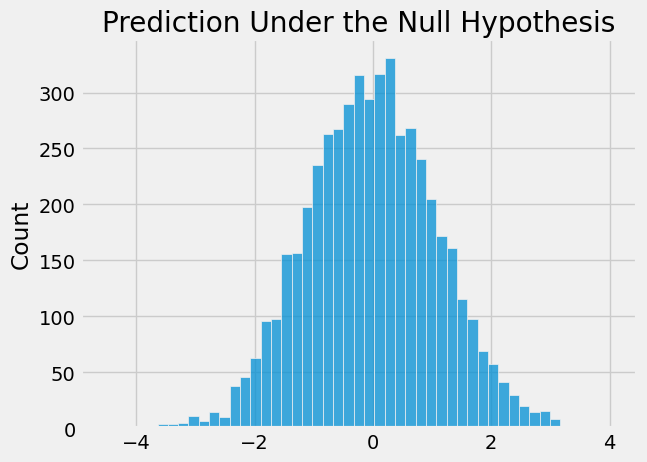

In [106]:
sns.histplot(differences);
print('Observed Difference:', observed_difference)
plt.title('Prediction Under the Null Hypothesis');

Observe como a distribuição é centrada aproximadamente em 0. Isso faz sentido, porque sob a hipótese nula os dois grupos deveriam ter aproximadamente a mesma média. Portanto, a diferença entre as médias do grupo deve ser em torno de 0.

A diferença observada na amostra original é de cerca de $-9,27$ onças, que nem aparece na escala horizontal do histograma. O valor observado da estatística e o comportamento previsto da estatística sob a hipótese nula são inconsistentes.

A conclusão do teste é que os dados favorecem a alternativa em detrimento do nulo. Ele suporta a hipótese de que o peso médio ao nascer de bebês nascidos de mães que fumam é menor do que o peso médio de bebês nascidos de não fumantes.

Se você deseja calcular um valor-p empírico, lembre-se de que valores baixos da estatística favorecem a hipótese alternativa.

In [107]:
empirical_p = np.count_nonzero(differences <= observed_difference) / repetitions
empirical_p

0.0

O valor p empírico é 0, o que significa que nenhuma das 5.000 amostras permutadas resultou em uma diferença de -9,27 ou inferior. Esta é apenas uma aproximação. A chance exata de obter uma diferença nesse intervalo não é 0. Mas é extremamente pequena, de acordo com nossa simulação e, portanto, podemos rejeitar a hipótese nula.

## Outro Teste de Permutação
Podemos usar o mesmo método para comparar outros atributos dos fumantes e dos não fumantes, como a idade. Histogramas das idades dos dois grupos mostram que, na amostra, as mães que fumavam tendiam a ser mais jovens.

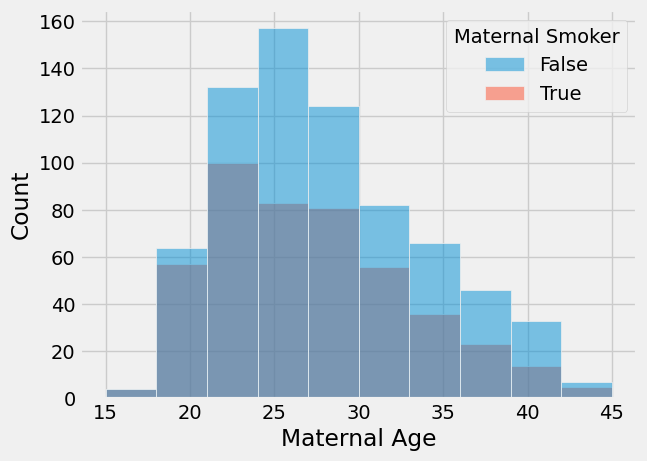

In [110]:
smoking_and_age = births.loc[:, ['Maternal Smoker', 'Maternal Age']]
sns.histplot(data = smoking_and_age, x = 'Maternal Age', hue = 'Maternal Smoker', bins=10);

A diferença observada entre as idades médias é de cerca de $-0,8$ anos.

Vamos reescrever o código que comparou os pesos de nascimento para que agora compare as idades dos fumantes e não fumantes.

In [117]:
def difference_of_means(table, group_label):
    """Takes: name of table,
    column label that indicates the group to which the row belongs
    Returns: Difference of mean birth weights of the two groups"""
    reduced = table.loc[:, ['Maternal Age', group_label]]
    means_table = reduced.groupby(group_label).mean()
    means = means_table['Maternal Age']
    return means[1] - means[0]

In [118]:
observed_age_difference = difference_of_means(births, 'Maternal Smoker')
observed_age_difference

-0.8076725017901509

Lembre-se de que a diferença é calculada como a idade média dos fumantes menos a idade média dos não fumantes. O sinal negativo mostra que os fumantes são, em média, mais jovens.

Essa diferença é devida ao acaso ou reflete uma diferença subjacente na população?

Como antes, podemos usar um teste de permutação para responder a essa pergunta. Se as distribuições subjacentes de idades nos dois grupos forem as mesmas, então a distribuição empírica da diferença baseada em amostras permutadas irá prever como a estatística deve variar devido ao acaso.

Seguiremos o mesmo processo de qualquer simulação. Começaremos escrevendo uma função que retorna um valor simulado da diferença entre as médias e, em seguida, escreveremos um loop `for` para simular vários desses valores e coletá-los em uma matriz.

In [119]:
def one_simulated_difference_of_means():
    """Returns: Difference between mean birthweights
    of babies of smokers and non-smokers after shuffling labels"""
    
    # array of shuffled labels
    shuffled_labels = births['Maternal Smoker'].sample(replace=False, n=len(births))
    # table of birth weights and shuffled labels
    shuffled_table = births.loc[:, ['Maternal Age']].copy()
    shuffled_table['Shuffled_Label'] = shuffled_labels.reset_index(drop=True)
    
    # difference between mean birth weights of the two groups
    return difference_of_means(shuffled_table, 'Shuffled_Label')   

In [120]:
age_differences = np.array([])

repetitions = 5000
for i in np.arange(repetitions):
    new_difference = one_simulated_difference_of_means()
    age_differences = np.append(age_differences, new_difference)

The observed difference is in the tail of the empirical distribution of the differences simulated under the null hypothesis. 

Observed Difference: -0.8076725017901509


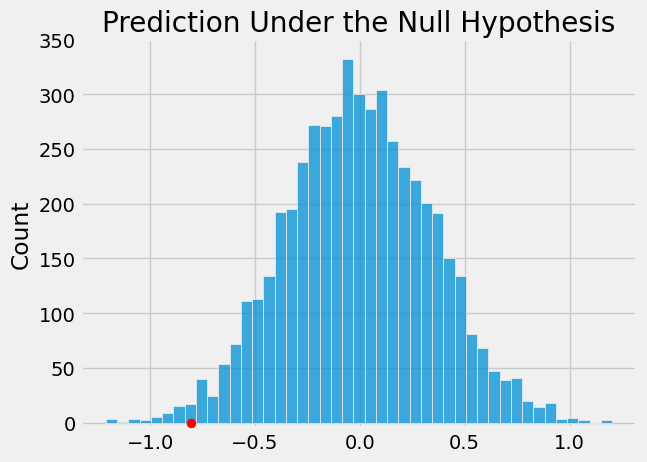

In [127]:
sns.histplot(age_differences);

plt.ylim(-5, 350)
plt.scatter(observed_age_difference, 0, color='red', s=40, zorder=3)
plt.title('Prediction Under the Null Hypothesis')
print('Observed Difference:', observed_age_difference)

Mais uma vez, a distribuição empírica das diferenças simuladas é centrada aproximadamente em torno de 0, porque a simulação está sob a hipótese nula de que não há diferença entre as distribuições dos dois grupos.

O p-valor empírico do teste é a proporção de diferenças simuladas que foram iguais ou menores que a diferença observada. Isso ocorre porque valores baixos da diferença favorecem a hipótese alternativa de que os fumantes eram, em média, mais jovens.

In [128]:
empirical_p = np.count_nonzero(age_differences <= observed_age_difference) / 5000
empirical_p

0.0096

O p-valor empírico é de cerca de 1% e, portanto, o resultado é estatisticamente significativo. O teste apóia a hipótese de que os fumantes eram, em média, mais jovens.